### Read the dataset

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('all_brands_combined_mobile_data_final.csv')
df.head(20)

,Post ID,Text,Product Brand
0,0,As someone who previously owned an Apple flags...,Google Pixel
1,1,Téléphone portable pixels 9 pro très satisfait...,Google Pixel
2,2,"Good phone, but it does not have the best batt...",Google Pixel
3,3,"Hello Buyer,\n\nI recently purchased the Pixel...",Google Pixel
4,4,"Okay, so my old phone was 6 years old and it s...",Google Pixel
5,5,I won't write a paragraph on how it's better i...,Google Pixel
6,6,I like the device and it's working god now but...,Google Pixel
7,7,I've had it for a few days. So far so good. Ca...,Google Pixel
8,8,"I purchased several of these for a project, re...",Google Pixel
9,9,"Came earlier than expected, good value for mon...",Google Pixel


### Using OpenAI API for getting the scores

Processed 100 reviews so far...
Processed 200 reviews so far...
Processed 300 reviews so far...
Processed 400 reviews so far...
Processed 500 reviews so far...
Processed 600 reviews so far...
Processed 700 reviews so far...
Processed 800 reviews so far...
Processed 900 reviews so far...
Processed 1000 reviews so far...
Processed 1100 reviews so far...
Processed 1200 reviews so far...
Processed 1300 reviews so far...
Processed 1400 reviews so far...
Processed 1500 reviews so far...
Processed 1600 reviews so far...
Processed 1700 reviews so far...
Processed 1800 reviews so far...
Processed 1900 reviews so far...
Processed 2000 reviews so far...
Processed 2100 reviews so far...
Processed 2200 reviews so far...
Processed 2300 reviews so far...
Processed 2400 reviews so far...
Processed 2500 reviews so far...
Processed 2600 reviews so far...
Processed 2700 reviews so far...
Processed 2800 reviews so far...
Processed 2900 reviews so far...
Processed 3000 reviews so far...
Processed 3100 revi

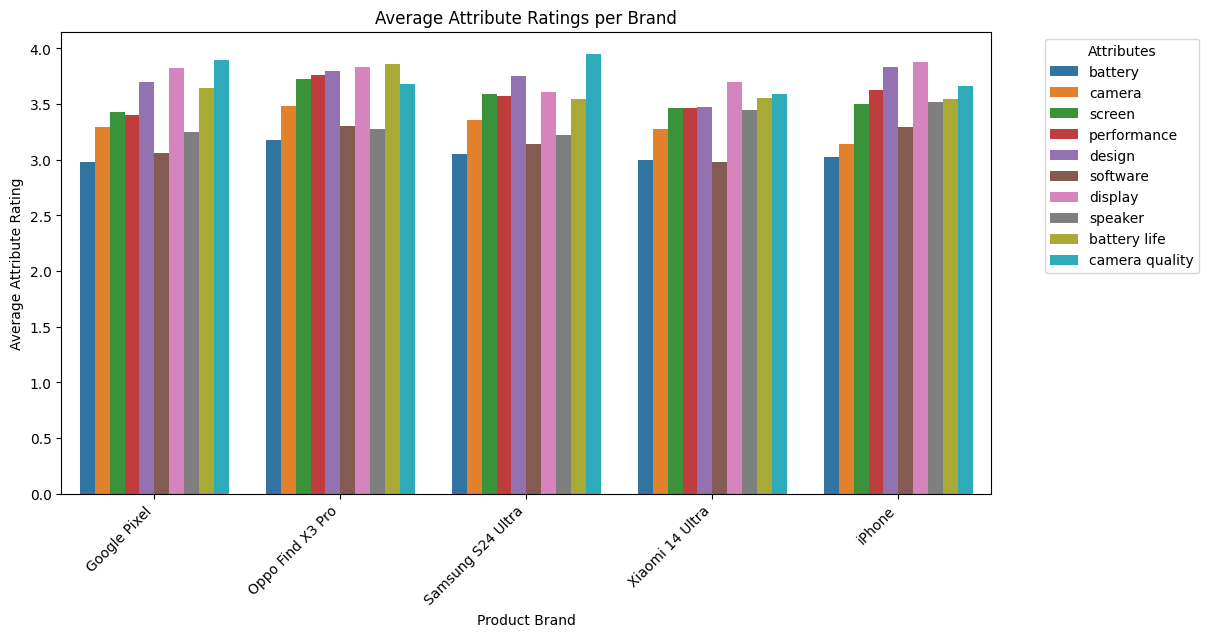

In [ ]:
import openai
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import numpy as np

nlp = spacy.load("en_core_web_sm")

attributes = ['battery', 'camera', 'screen', 'performance', 'design', 'software', 'display', 'speaker', 'battery life', 'camera quality']

def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df[df['Text'].str.len() >= 10]
    return df

def analyze_text_openai(text, api_key):
    openai.api_key = api_key
    messages = [
        {"role": "system", "content": "You are an advanced NLP assistant specializing in product review analysis. Your task is to extract key product attributes and analyze sentiment with precision."}, 
        {"role": "user", "content": f"""Analyze the following review and perform the following tasks:
        
    1. **Extract key attributes** mentioned in the review.  
    2. **Provide a sentiment score** between -1 and 1 for the overall sentiment of the review.  
    3. **Assign a rating (1-5) for each attribute**: Based on sentiment analysis, rank each of the following attributes: {', '.join(attributes)}.  
    - If an attribute is **not mentioned**, do not include it in the output.  
    - Ensure the output follows the exact format below:  

    **Output Format:**  
    - **Key Attributes:** <comma-separated extracted attributes>  
    - **Sentiment Score:** <score between -1 and 1>  
    - **Attribute Ratings:**  
    - <attribute>: <1-5>  
    - <attribute>: <1-5>  

    **Review:**  
    {text}  
    """}
    ]

    
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo-16k",
        messages=messages
    )
    response_text = response["choices"][0]["message"]["content"]
    return response_text

def extract_sentiment_score(response_text):
    match = re.search(r"Sentiment Score:\s*(-?\d*\.\d+|-?\d+)", response_text)
    if match:
        try:
            return float(match.group(1))
        except (AttributeError, ValueError):
            return 0 
    return 0

def extract_attribute_ratings(response_text):
    attribute_ratings = {}
    matches = re.findall(r"(\w+(?:\s\w+)?):\s*(\d)", response_text)
    for attr, rating in matches:
        if attr.lower() in attributes:
            attribute_ratings[attr.lower()] = int(rating)
    return attribute_ratings

def extract_attributes_and_sentiment(df, api_key):
    records = []
    
    for index, row in df.iterrows():
        response_text = analyze_text_openai(row['Text'], api_key)
        sentiment_score = extract_sentiment_score(response_text)
        attribute_ratings = extract_attribute_ratings(response_text)
        
        record = {
            'Post ID': row['Post ID'],
            'Product Brand': row['Product Brand'],
            'Sentiment Score': sentiment_score,
        }
        for attr in attributes:
            record[attr] = attribute_ratings.get(attr, None)
        
        records.append(record)
        
        if (index + 1) % 100 == 0:
            print(f"Processed {index + 1} reviews so far...")
    
    df_results = pd.DataFrame(records)
    df_results.to_csv("attribute_sentiment_results.csv", index=False)
    print("Processing complete. Results saved.")
    return df_results

def normalize_sentiment(sentiment_score):
    if sentiment_score <= -0.6:
        return 1
    elif sentiment_score <= -0.2:
        return 2
    elif sentiment_score <= 0.2:
        return 3
    elif sentiment_score <= 0.6:
        return 4
    else:
        return 5

def visualize_brand_attribute_ratings(df_results):
    df_melted = df_results.melt(id_vars=['Product Brand'], value_vars=attributes, var_name='Attribute', value_name='Rating')
    df_melted = df_melted.dropna()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_melted, x='Product Brand', y='Rating', hue='Attribute', errorbar=None)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Product Brand")
    plt.ylabel("Average Attribute Rating")
    plt.title("Average Attribute Ratings per Brand")
    plt.legend(title="Attributes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

def main(csv_path, api_key):
    df = load_data(csv_path)
    df_results = extract_attributes_and_sentiment(df, api_key)
    visualize_brand_attribute_ratings(df_results)

if __name__ == "__main__":
    main("filtered_all_brands_combined_mobile_data_final(in).csv", api_key)


### Creating a chart 

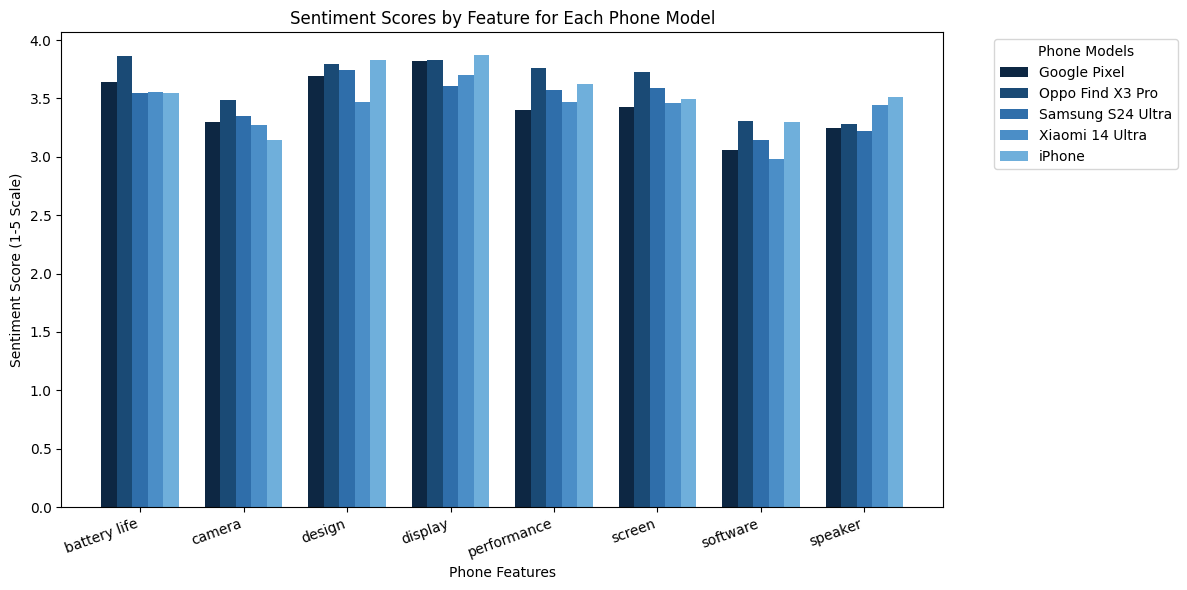

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path = "attribute_sentiment_results.csv" 
df = pd.read_csv(csv_path)


if "Product Brand" not in df.columns:
    raise ValueError("The input CSV does not contain a 'Product Brand' column.")

feature_columns = df.columns[3:] 

if "camera quality" in feature_columns:
    feature_columns = feature_columns.drop(["camera quality","battery"])

df[feature_columns] = df[feature_columns].apply(pd.to_numeric, errors="coerce")

brand_sentiment_df_5scale = df.groupby("Product Brand")[feature_columns].mean()

brand_sentiment_df_5scale = brand_sentiment_df_5scale.sort_index(axis=1)
features = brand_sentiment_df_5scale.columns
brands = brand_sentiment_df_5scale.index 

x = np.arange(len(features))
width = 0.15

custom_colors = ["#0D2743", "#1A4A75", "#2F6EAA", "#4B8EC7", "#6FAFDB"]


fig, ax = plt.subplots(figsize=(12, 6))


for i, (brand, color) in enumerate(zip(brands, custom_colors * (len(brands) // len(custom_colors) + 1))):
    ax.bar(x + i * width, brand_sentiment_df_5scale.loc[brand], width, label=brand, color=color)

ax.set_xlabel("Phone Features")
ax.set_ylabel("Sentiment Score (1-5 Scale)")
ax.set_title("Sentiment Scores by Feature for Each Phone Model")
ax.set_xticks(x + width * (len(brands) / 2 - 0.5))
ax.set_xticklabels(features, rotation=20, ha="right")
ax.legend(title="Phone Models", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
